In [3]:
import numpy as np
import os
import netCDF4
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from sstanalysis import gfd
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

In [4]:
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'

In [5]:
p = popmodel.POPFile(fname)

In [6]:
#T = p.nc.variables['SST']
#Nt, Nx, Ny, k, l, PSD_sum = p.power_spectrum_2d(T)

# Sea-Surface Temperature #

## Python FFT equation ##
## 1D ##

$$ \tilde{x}(j) = \sum_{k=0}^{N-1} x(k) e^{-\frac{2\pi i}{N}kj} = \sum_{k=0}^{N-1} x(k) e^{-i\Delta \omega j k} $$

where $ \omega = \Delta \omega j $ and $ \Delta \omega = \frac{2\pi}{N} $. On the other hand, the infinite Fourier transform is

$$ \hat{x}(j) = \int x(k) e^{-\frac{2\pi i}{N}kj} dk $$

where $\hat{x} \ \ [^\circ C \ m]$ is the theoretical Fourier coefficients and $\tilde{x} \ \ [^\circ C]$ is the Fourier coefficients derived by the python algorithm. Hence, for the discrete & infinite Fourier transforms to have the same dimensions, 

$$ \hat{x}(j) = \int x(k) e^{-\frac{2\pi i}{n}kj} dk \approx \Delta k \  \sum_{k=0}^{N-1}  x(k) e^{-\frac{2\pi i}{n}kj} $$

In our case, this becomes

$$ \tilde{T}(k) = \sum_{n=0}^{N-1} T(x_n) e^{-i k x_n} \ \ \ [^\circ C] $$

$$ \hat{T}(k) = \int T(x) e^{-ikx} dx \approx \Delta x \  \sum_{n=0}^{N-1} T(x_n) e^{-ikx_n} = \Delta x \ \tilde{T}(k) \ \  [^\circ C \ m] $$

where $\hat{T} \ \ [^\circ C \ m]$ is the theoretical Fourier coefficients and $\tilde{T} \ \ [^\circ C]$ is the Fourier coefficients derived by the python algorithm. $ k $ is the wavenumber, $ x $ is the spatial length and $ \Delta x $ is the grid increments, the PSD is calculated as

$$ E = \int_{-\infty}^{\infty} P(k) \ dk = \sum_n |\tilde{T}(k_n)|^2 \ \ \ [^\circ C^2] \ \ \ (*) $$

On the other hand,

$$ E = \int_{-\infty}^{\infty} |\hat{T}(k)|^2 dk \ \ \ [^\circ C^2 m] $$

Using $(*)$, the power spectral density is

$$ P(k) = \frac{|\tilde{T}(k_i)|^2}{\Delta k} $$

## 2D ##

$$ \hat{T}(k,l) = \iint T(x,y) e^{-i(kx+ly)} dx dy \approx \Delta x \Delta y \  \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} T(x_m, y_n) e^{-i(kx_m+ly_n)} = \Delta x \Delta y \ \big| \tilde{T}(x,y) \big| \ \  [^\circ C \ m^2] $$

where $ k, l $ are the wavenumbers, $ x,y $ is the spatial lengths and $ \Delta x, \Delta y $ are the grid increments so, the PSD is calculated as

$$ E = \iint P(k,l) dk \ dl = \sum_m \sum_n |\tilde{T}(k_m,l_n)|^2 \ \ \ [^\circ C^2] \ \ \ (**) $$

On the other hand,

$$ E = \iint | \hat{T} (k,l) |^2 dk \ dl \ \ \ [^\circ C\ m^2] $$

Using $(**)$, the power spectral density is

$$ P(k,l) = \frac{|\tilde{T}(k_m,l_n)|^2}{\Delta k \Delta l} $$

# Isotropic Spectra #

## Webb (1964) / McCaffrey (2014) ##

Webb's original paper only deals with 1D signals and spectra while McCaffrey deals with 2D isotropic spectra. This is a subtle but crucial difference. For the proof of the relation between spectra and the structure function, the spectra must satisfy:

$$ \langle \theta^2 \rangle = \int_{0}^{\infty} B(K) \ dK $$

Let's unpack this a little bit.

## 1D signal ##

For a 1D signal, the left-hand side of the equation above represents an integral over $x$. The domain-integrated variance is defined as:

$$ \langle \theta^2 \rangle = \int_{-\infty}^{\infty} \theta^2 (x) dx \ \ \ [^\circ C^2\ m] $$

We define the theoretical Fourier transform $\hat{\theta}(k)$ via the following relation:

$$ \theta (x) = \frac{1}{2\pi} \int_{-\infty}^{\infty} \hat{\theta}(k) e^{ikx} dk $$

$$ \hat{\theta} (k) = \int_{-\infty}^{\infty} \theta (x) e^{-ikx} dx $$

The [Plancherel Theorem](http://en.wikipedia.org/wiki/Fourier_transform#Plancherel_theorem_and_Parseval.27s_theorem) states that

$$ E = \int_{-\infty}^{\infty} | \theta (x) |^2 dx = \int_{-\infty}^{\infty} | \hat{\theta} (k) |^2 dk = \sum_{i} | \tilde{\theta} (k) |^2 $$

$$ P(k) = | \hat{\theta} (k) |^2 $$

All we have to do to satisfy Webb's condition is to set $K=k$, assume that $ |\hat{\theta}(-k)|^2 = |\hat{\theta}(k)|^2 $ (always true for a real function) and define

$$ B_{1D}(K) = 2|\hat{\theta}(K)|^2 = 2\big( \frac{1}{\Delta k} \big)^2 \ |\tilde{\theta}(K)|^2 $$

## 2D signal ##

The situation for a 2D field is more complicated. The domain integrated variance is

$$ \langle \theta^2 \rangle = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta^2 (x,y) \ dxdy \ \ \ [^\circ C^2\ m^2] $$

The Fourier pairs are

$$ \theta(x,y) = \frac{1}{(2\pi)^2} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \hat{\theta}(k,l) e^{i(kx+ly)} dkdl $$

$$ \hat{\theta}(k,l) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta(x,y) e^{-i(kx+ly)} dxdy = \Delta x \Delta y \sum_m \sum_n \theta(x_m,y_n) e^{-i(kx_m+ly_n)} = \Delta x \Delta y \ \tilde{\theta}(x_m,y_n) \ \ \ [^\circ C\ m^2 ] $$

The Plancherel theorem still looks the same

$$ E = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta (x,y)^2 dxdy = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} | \hat{\theta} (k,l) |^2 dkdl $$

Hence

$$ E = \iint P(k,l) dk\ dl = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} | \hat{\theta} (k,l) |^2 dkdl = \Delta k \Delta l \sum_i \sum_j |\hat{\theta}(k_i,l_j)|^2 = \Delta k \Delta l (\Delta x \Delta y)^2 \sum_j |\tilde{\theta}(k_i,l_j)|^2 $$

$$ P(k,l) = \bigg( \Delta x \Delta y\ \big|\tilde{\theta}(k_i,l_j)\big| \bigg)^2 $$

where $\hat{\theta} \ \ [^\circ C \ m^2]$ is the theoretical Fourier coefficients and $\tilde{\theta} \ \ [^\circ C]$ is the Fourier coefficients derived by the python algorithm. The frequencies are defined as

$$ k = \frac{(0,1,2,\cdot\cdot\cdot,\frac{N}{2}-1)}{N\Delta x} $$

so 

$$ \Delta k = \frac{1}{N\Delta x}, \ \ \ \Delta x = \frac{1}{N \Delta k} $$

However, the isotropic spectrum needs to be defined carefully. For any signal $f(k,l)$, we can transform to polar coordinates $f(K,\phi)$ where

$$ K = \sqrt{k^2+l^2}, \ \ \ \phi = \arctan\bigg[ \frac{l}{k} \bigg] $$

the integral of $f$ over all $k$ and $l$ is written as

$$ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(k,l) \ dkdl = \int_{0}^{\infty} \int_{-\pi}^{\pi} f(K, \phi)\ J_f d\phi dK = \int_{0}^{\infty} \Big(\int_{-\pi}^{\pi} f(K, \phi) K \ d\phi \Big) dK $$

where the Jacobian is

$$ J_f = \frac{\partial (k,l)}{\partial (K,\phi)} = \Bigg| \begin{matrix} \cos\theta &\sin\theta \\ -K\sin\theta &K\cos\theta \end{matrix} \Bigg| = K $$

The key point is that, due to transformation to polar coordinates, we pick up an extra factor of $K$ in the integral. In order to satisfy Webb's condition in 2D, we need 

$$ \langle \theta^2 \rangle = \int_{0}^{\infty} B(K, \phi) \ dK = \int_{0}^{\infty} \Big(\int_{-\pi}^{\pi} |\hat{\theta}(K, \phi)|^2 K \ d\phi \Big) dK $$

$$ B_{2D}(K, \phi) = \int_{-\pi}^{\pi} |\hat{\theta}(K, \phi)|^2 K \ d\phi \ \ \ [^\circ C^2 m] $$

For a isotropic field, this reduces to

$$ B_{2D}(K) = \int_{-\pi}^{\pi} |\hat{\theta}(K)|^2 K \ d\phi = 2\pi K |\hat{\theta}(K)|^2 $$

$$ \langle \theta^2 \rangle = \int_{0}^{\infty} \ B_{2D}(K) \ dK = \sum_{i} B_{2D}(K_i) \Delta K = \sum_{i} 2\pi K_i | \hat{\theta}(K_i)|^2 \Delta K = \sum_{i} | \tilde{\theta}(K_i)|^2 $$

Now, the relation between the Cartesian and polar coordinate for the Fourier components are

$$ \frac{1}{\Delta k\Delta l} |\hat{\theta}(k,l)|^2 = |\tilde{\theta}(k,l)|^2 \Leftrightarrow \frac{1}{K \Delta K\Delta \phi} |\hat{\theta}(K,\phi)|^2 = |\tilde{\theta}(K,\phi)|^2 \ \ \ [^\circ C^2] $$

In an isotrophic state

$$ \frac{1}{2\pi K \Delta K} |\hat{\theta}(K)|^2 = |\tilde{\theta}(K)|^2 $$

Hence the power $ B_{2D}(K_i) $ is

$$ \therefore B_{2D}(K_i) = \frac{\big| \tilde{\theta}(K_i) \big|^2 }{\Delta K} $$

The last equal sign comes from $\hat{\theta}(k,l) = \hat{\theta}(k_h,\phi)$, which is simply writing the same field in different coordinates. This means that if we want $B_{2D}(K) = B_0{K}^{\alpha}$, we need

$$ {r_{k,l}}^2 \approx |\hat{\theta}(k,l)|^2 = (2\pi)^{-1} K^{-1} B_{2D}(K) = (2\pi)^{-1} B_0{K}^{\alpha-1} $$

On the other hand, in the python algorithm, the discrete Fourier transforms only computes the Fourier coefficients $\tilde{T}(k,l) \ \ [^\circ C]$ so

$$ E = \big\langle T^2(k,l) \big\rangle = \sum_{i=0}^{N-1} \sum_{j=0}^{N-1} {\big| \tilde{T}(k_i,l_j) \big|}^2 \ \ \ [^\circ C^2] $$

thus

$$ E = \int P(K) \ dK = \sum_i P(K_i) \Delta K \ ; \ \ \ P(K_i) \ \ \ [^\circ C^2 m] $$

where $\Delta K_i \approx \Delta K =$ const.

In [218]:
Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb, Ki, isospec_Feb, area, lon, lat, frac, MAX_LAND = p.power_spectrum_2d()

/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


<matplotlib.colorbar.Colorbar instance at 0x7f04d83e23f8>

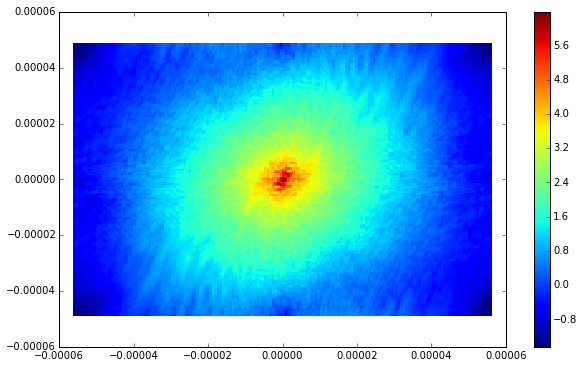

In [219]:
plt.figure(figsize=(10,6))
plt.pcolormesh(k,l,np.log10(PSD_sum_Feb/Nt_Feb))
plt.colorbar()

In [7]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb, Ki, isospec_Feb, area, lon, lat, land_frac, crit = p.power_spectrum_2d()
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Feb = np.zeros(N)
    isospec_sum_Feb += isospec_Feb
    #NtFeb += Nt_Feb

isospec_ave_Feb = isospec_sum_Feb/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


sstanalysis/popmodel.py:235: RuntimeWarning: invalid value encountered in divide
  np.bincount(Kidx, weights=(PSD_ave).ravel()) / area )[1:] *2.*np.pi/deltaKi
/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [8]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug, Ki, isospec_Aug, area, lon, lat, land_frac, crit = p.power_spectrum_2d()
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Aug = np.zeros(N)
    isospec_sum_Aug += isospec_Aug
    #NtAug += Nt_Aug

isospec_ave_Aug = isospec_sum_Aug/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


## Fitting Linear Relation ##

In [9]:
def fit_loglog(x, y):
    # fig log vs log
    p = np.polyfit(np.log2(x), np.log2(y), 1)
    y_fit = 2**(np.log2(x)*p[0] + p[1])
    #A = np.vstack([np.log2(x), np.ones(len(x))]).T
    #a, b = np.linalg.lstsq(A, np.log2(y))[0]
    #y_fit = 2**(np.log2(x)*a + b)
    
    return y_fit, p[0]

In [10]:
Ns = 15
Ne = N/4
ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])

print ps_slope_Feb, ps_slope_Aug

-3.31894070754 -3.63886722727


(array([  1.00000000e+04,   1.00000000e+05,   1.00000000e+06,
          1.00000000e+07,   1.00000000e+08,   1.00000000e+09,
          1.00000000e+10,   1.00000000e+11,   1.00000000e+12,
          1.00000000e+13,   1.00000000e+14,   1.00000000e+15,
          1.00000000e+16,   1.00000000e+17]),
 <a list of 14 Text yticklabel objects>)

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/scale.py:93: RuntimeWarning: invalid value encountered in less_equal
  mask = a <= 0.0


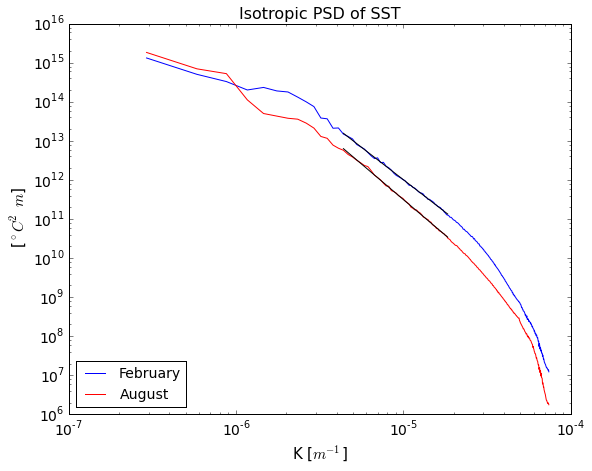

In [11]:
plt.figure(figsize=(9,7))
plt.loglog(Ki, isospec_ave_Feb, 'b', label=r'February')
plt.loglog(Ki, isospec_ave_Aug, 'r', label=r'August')
plt.loglog(Ki[Ns:Ne], ps_fit_Feb, 'k')
plt.loglog(Ki[Ns:Ne], ps_fit_Aug, 'k')
plt.xlabel('K [$m^{-1}$]', fontsize=15)
plt.ylabel(' [$^\circ C^2 \ m$]', fontsize=15)
plt.title('Isotropic PSD of SST', fontsize=16)
plt.legend(loc='lower left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## Structure Function ##

In [39]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, dx, dy, L_Feb, SFi, SFj, lon, lat = p.structure_function()
    if yearnum == 1:
        N = len(L_Feb)
        StrucFunc_sum_Febi = np.zeros(N)
        StrucFunc_sum_Febj = np.zeros(N)
    StrucFunc_sum_Febi += SFi
    StrucFunc_sum_Febj += SFj
    NtFeb += Nt_Feb

StrucFunc_ave_Febi = StrucFunc_sum_Febi/NtFeb
StrucFunc_ave_Febj = StrucFunc_sum_Febj/NtFeb
StrucFunc_ave_Feb = .5*(StrucFunc_ave_Febi+StrucFunc_sum_Febj)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [40]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, dx, dy, L_Aug, SFi, SFj, lon, lat = p.structure_function()
    if yearnum == 1:
        N = len(L_Aug)
        StrucFunc_sum_Augi = np.zeros(N)
        StrucFunc_sum_Augj = np.zeros(N)
    StrucFunc_sum_Augi += SFi
    StrucFunc_sum_Augj += SFj
    NtAug += Nt_Aug

StrucFunc_ave_Augi = StrucFunc_sum_Augi/NtAug
StrucFunc_ave_Augj = StrucFunc_sum_Augj/NtAug
StrucFunc_ave_Aug = .5*(StrucFunc_ave_Augi+StrucFunc_sum_Augj)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


In [41]:
sf_fit_Feb, sf_slope_Feb = fit_loglog(L_Feb, StrucFunc_ave_Feb)
sf_fit_Aug, sf_slope_Aug = fit_loglog(L_Aug, StrucFunc_ave_Aug)

print sf_slope_Feb, sf_slope_Aug

0.964110784828 1.14398761495


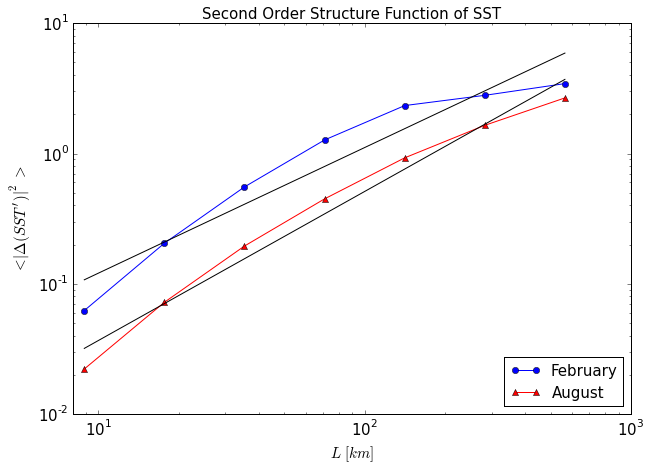

In [60]:
x = 2**np.arange(N)*dx*1e-3
y = 2**np.arange(N)*dy*1e-3

plt.figure(figsize=(10,7))
blue, = plt.loglog(x, StrucFunc_ave_Feb, 'bo-', basex=10, basey=10)
red, = plt.loglog(x, StrucFunc_ave_Aug, 'r^-', basex=10, basey=10) 
black, = plt.loglog(x, sf_fit_Feb, 'k')
black, = plt.loglog(x, sf_fit_Aug, 'k')
plt.title('Second Order Structure Function of SST', fontsize=15)
plt.xlabel('$L \  [km]$', fontsize=15)
plt.ylabel('$< {| \Delta ({SST}^{\ \prime}) |}^2 >$', fontsize=15)
plt.xlim([8e0, 1e3])
plt.ylim([1e-2, 1e1])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend([blue, red], ['February', 'August'], loc=4, fontsize=15)

The spectral slopes were -2.32 and -2.65 for Feburary and August respectively. On the other hand the structure-function slopes were 0.96 and 1.14 for February and August respectively. Remembering that the relation between spectral slope $(\alpha)$ and structure-function slope $(\gamma)$ was
$$ \gamma = -\alpha-1 $$
and the bias that sturcture functions would be shallower than the slopes predicted from spectra, the slopes of our analysis seem to agree fairly well with theory.

It may also be interesting to note that while the slopes were shallower for February than August, February always had higher amplitudes in spectra and the structure function.

# Surface Velocity #
## Isotropic Spectra ##

In [5]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb_u, Ki, isospec_Feb_u, area, lon_vel, lat_vel, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='U1_1', lonname='ULONG', latname='ULAT', maskname='KMU')
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb_v, Ki, isospec_Feb_v, area, lon_vel, lat_vel, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='V1_1', lonname='ULONG', latname='ULAT', maskname='KMU')
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Feb_u = np.zeros(N)
        isospec_sum_Feb_v = np.zeros(N)
    isospec_sum_Feb_u += isospec_Feb_u
    isospec_sum_Feb_v += isospec_Feb_v
    #NtFeb += Nt_Feb

isospec_ave_Feb_u = isospec_sum_Feb_u/yearnum
isospec_ave_Feb_v = isospec_sum_Feb_v/yearnum
isospec_ave_Feb_Vel = .5*(isospec_ave_Feb_u + isospec_ave_Feb_v)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


sstanalysis/popmodel.py:231: RuntimeWarning: invalid value encountered in divide
  np.bincount(Kidx, weights=(PSD_ave).ravel()) / area )[1:] *Ki*2.*np.pi/deltaKi
/usr/local/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:790: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


In [6]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug_u, Ki, isospec_Aug_u, area, lon_vel, lat_vel, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='U1_1', lonname='ULONG', latname='ULAT', maskname='KMU')
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug_v, Ki, isospec_Aug_v, area, lon_vel, lat_vel, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='V1_1', lonname='ULONG', latname='ULAT', maskname='KMU')
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Aug_u = np.zeros(N)
        isospec_sum_Aug_v = np.zeros(N)
    isospec_sum_Aug_u += isospec_Aug_u
    isospec_sum_Aug_v += isospec_Aug_v
    #NtFeb += Nt_Feb

isospec_ave_Aug_u = isospec_sum_Aug_u/yearnum
isospec_ave_Aug_v = isospec_sum_Aug_v/yearnum
isospec_ave_Aug_Vel = .5*(isospec_ave_Aug_u + isospec_ave_Aug_v)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


# Sea-Surface Height #
## Isotropic Spectra ##

In [7]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx_H, Ny_H, k_H, l_H, PSD_Feb_H, Ki_H, isospec_Feb_H, area, lon_SSH, lat_SSH, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='SSH_2', lonname='TLONG', latname='TLAT', maskname='KMT')
    if yearnum == 1:
        N = len(Ki_H)
        isospec_sum_Feb_H = np.zeros(N)
        L,K = PSD_Feb_H.shape
        PSD_sum_Feb_H = np.zeros((L,K))
    PSD_sum_Feb_H += PSD_Feb_H
    isospec_sum_Feb_H += isospec_Feb_H
    #NtFeb += Nt_Feb

isospec_ave_Feb_SSH = isospec_sum_Feb_H/yearnum
PSD_ave_Feb_SSH = PSD_sum_Feb_H/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [8]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx_H, Ny_H, k_H, l_H, PSD_Aug_H, Ki_H, isospec_Aug_H, area, lon_SSH, lat_SSH, land_frac, crit = p.power_spectrum_2d(
                                                                                        varname='SSH_2', lonname='TLONG', latname='TLAT', maskname='KMT')
    if yearnum == 1:
        N = len(Ki_H)
        isospec_sum_Aug_H = np.zeros(N)
        L,K = PSD_Aug_H.shape
        PSD_sum_Aug_H = np.zeros((L, K))
    isospec_sum_Aug_H += isospec_Aug_H
    PSD_sum_Aug_H += PSD_Aug_H
    #NtFeb += Nt_Feb

isospec_ave_Aug_SSH = isospec_sum_Aug_H/yearnum
PSD_ave_Aug_SSH = PSD_sum_Aug_H/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


In [9]:
Ns = 20
Ne = N/5
ps_fit_Feb_Vel, ps_slope_Feb_Vel = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb_Vel[Ns:Ne])
ps_fit_Aug_Vel, ps_slope_Aug_Vel = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug_Vel[Ns:Ne])

ps_fit_Feb_SSH, ps_slope_Feb_SSH = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb_SSH[Ns:Ne])
ps_fit_Aug_SSH, ps_slope_Aug_SSH = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug_SSH[Ns:Ne])

print ps_slope_Feb_Vel, ps_slope_Aug_Vel
print ps_slope_Feb_SSH, ps_slope_Aug_SSH

NameError: name 'fit_loglog' is not defined

From geostrophic balance

$$ \textbf{u} = \frac{g}{f} \ \textbf{k} \times \nabla \eta $$

and expressing both sides as Fourier components

$$ u = \int \tilde{u}(k,l) \ e^{i(kx+ly)} \ dkdl = -\frac{g}{f} \ \frac{\partial}{\partial y} \int \tilde{\eta}(k,l) \ e^{i(kx+ly)} \ dkdl = -i\frac{g}{f} \int l \ \tilde{\eta}(k,l) \ e^{i(kx+ly)} \ dkdl = \frac{g}{f} \int l \ \tilde{\eta}(k,l) \ e^{i(kx+ly-\frac{\pi}{2})} \ dkdl $$

$$ v = \int \tilde{v}(k,l) \ e^{i(kx+ly)} \ dkdl = \frac{g}{f} \ \frac{\partial}{\partial x} \int \tilde{\eta}(k,l) \ e^{i(kx+ly)} \ dkdl = i\frac{g}{f} \int k \ \tilde{\eta}(k,l) \ e^{i(kx+ly)} \ dkdl = \frac{g}{f} \int k \ \tilde{\eta}(k,l) \ e^{i(kx+ly+\frac{\pi}{2})} \ dkdl $$

Hence, 

$$ \frac{1}{2} \big( u^2+v^2 \big) = \frac{1}{2} \int^{\infty}_{-\infty} \big( |\tilde{u}|^2(k,l) + |\tilde{v}|^2(k,l) \big) \ dkdl = \frac{1}{2} \Big(\frac{g}{f} \Big)^2 \int^{\infty}_{-\infty} K^2 |\tilde{\eta}|^2(k,l) \ dkdl $$

$<$Supplement$>$
The variable $\tilde{\eta}(k,l)$ is also a complex number, viz

$$ \tilde{\eta}(k,l) = r \ e^{i\phi} $$

$$ \therefore i \ \tilde{\eta}(k,l) = i \ r \big( \cos (kx+ly)+i\sin (kx+ly) \big) = r \big( i\cos (kx+ly)-\sin (kx+ly) \big) $$

$$ |\tilde{\eta}|^2(k,l) = \tilde{\eta}(k,l) {\tilde{\eta}}^*(k,l) = r^2 e^{i\phi} e^{-i\phi} = r^2 $$

In [ ]:
plt.figure()
plt.plot(k_H[len(k_H)/2:])
print k_H[0], k_H[-1], k_H[len(k_H)/2], k_H[len(k_H)/2+1] 
print k_H.max()

In [ ]:
grav = gfd.g
cori = gfd.f_coriolis(.5*(lat_SSH[0,0]+lat_SSH[-1,0]))
print cori
#nbins = 256

#kk, ll = np.meshgrid(k_H, l_H)
#K = np.sqrt(kk**2 + ll**2)
#PSD_Vel_Feb_SSH = .5*(grav*K/cori)**2*PSD_ave_Feb_SSH
#PSD_Vel_Aug_SSH = .5*(grav*K/cori)**2*PSD_ave_Aug_SSH
#Ki_H = np.linspace(0., K.max(), nbins)
#Kidx_H = np.digitize(K.ravel(), Ki_H)
#area = np.bincount(Kidx)
#isotropic_PSD_Feb_Vel_H = np.ma.masked_invalid(
#                               np.bincount(Kidx_H, weights=(2./Nx_H**2/k_H[len(k_H)/2+1]/
#                                                          Ny_H**2/l_H[len(l_H)/2+1]*PSD_Vel_Feb_SSH*K*2.*np.pi).ravel()) / area )
#isotropic_PSD_Aug_Vel_H = np.ma.masked_invalid(
#                               np.bincount(Kidx_H, weights=(2./Nx_H**2/k_H[len(k_H)/2+1]/
#                                                          Ny_H**2/l_H[len(l_H)/2+1]*PSD_Vel_Aug_SSH*K*2.*np.pi).ravel()) / area )


fig = plt.figure(figsize=(20,6))
        
ax1 = fig.add_subplot(131)
ax1.loglog(Ki*1e3, isospec_ave_Feb_Vel, 'b', label=r'February')
ax1.loglog(Ki*1e3, isospec_ave_Aug_Vel, 'r', label=r'August')
ax1.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb_Vel, 'k')
ax1.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug_Vel, 'k')
ax1.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax1.set_ylabel('$[m^3/s^2]$', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title('PSD of Surface Velocity', fontsize=15)
ax1.legend(loc='lower left')

ax2 = fig.add_subplot(132)
ax2.loglog(Ki*1e3, isospec_ave_Feb_SSH, 'b', label=r'February')
ax2.loglog(Ki*1e3, isospec_ave_Aug_SSH, 'r', label=r'August')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb_SSH, 'k')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug_SSH, 'k')
ax2.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax2.set_ylabel('$[m^3]$', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_title('PSD of SSH', fontsize=15)
ax2.legend(loc='lower left')

ax3 = fig.add_subplot(133)
ax3.loglog(Ki_H*1e3, .5*(grav*Ki_H/cori)**2*isospec_ave_Feb_SSH, 'c', label=r'February $\frac{1}{2}{(\frac{gK}{f}|\tilde{\eta}|)}^2$')
ax3.loglog(Ki_H*1e3, .5*(grav*Ki_H/cori)**2*isospec_ave_Aug_SSH, 'm', label=r'August $\frac{1}{2}{(\frac{gK}{f}|\tilde{\eta}|)}^2$')
ax3.loglog(Ki*1e3, isospec_ave_Feb_Vel, 'b', label=r'February (Vel)')
ax3.loglog(Ki*1e3, isospec_ave_Aug_Vel, 'r', label=r'August (Vel)')
ax3.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax3.set_ylabel('$[m^3/s^2]$', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_title('Comparison of SSH and Surface Velocity', fontsize=15)
ax3.legend(loc='lower left')

The kinetic energy spectra slopes are -2.90 and -4.12 for February and August respectively. The SSH spectra slopes are -4.09 and -5.37.

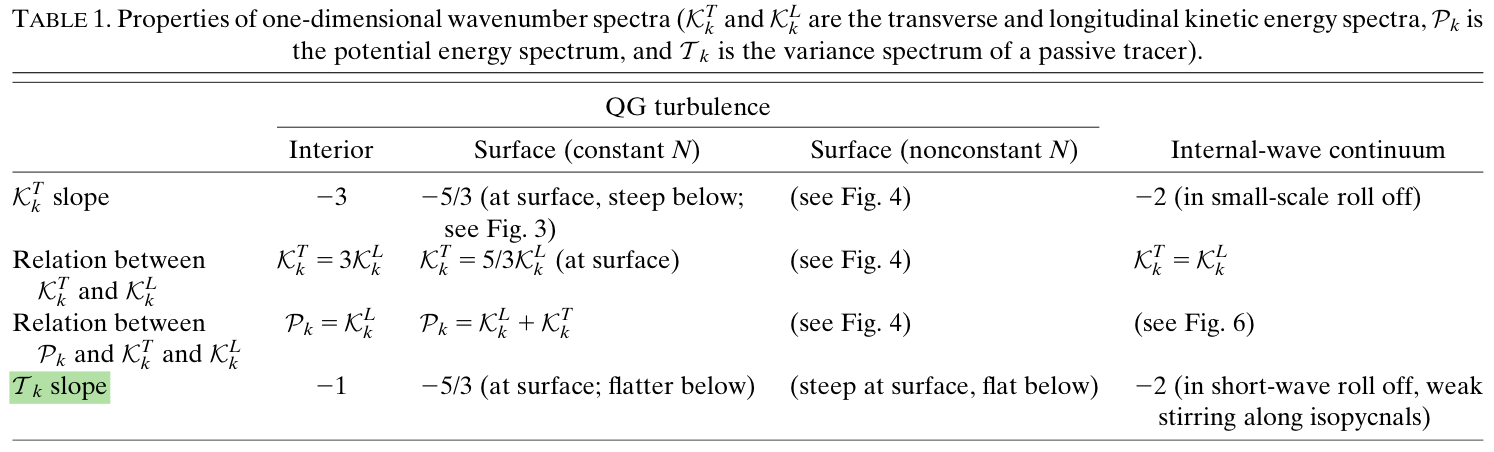

In [54]:
from IPython.display import Image
Image(filename='Callies_Ferrari_summary.png')

# Expand Domain #

1629 1836 1474 1688
11.767448308 49.2027441065 140.05 232.085004027


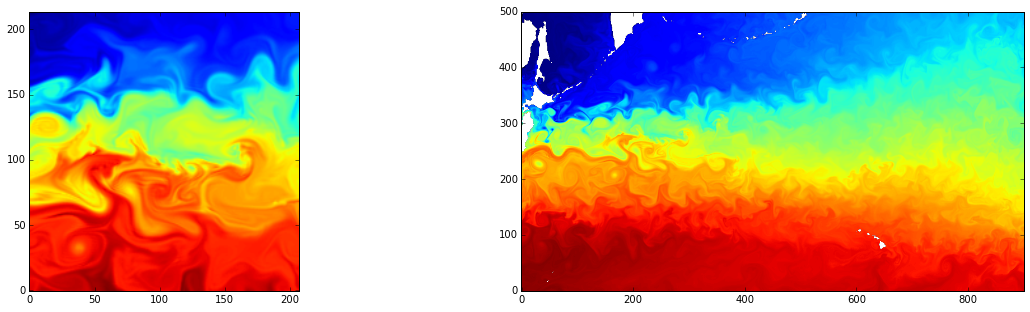

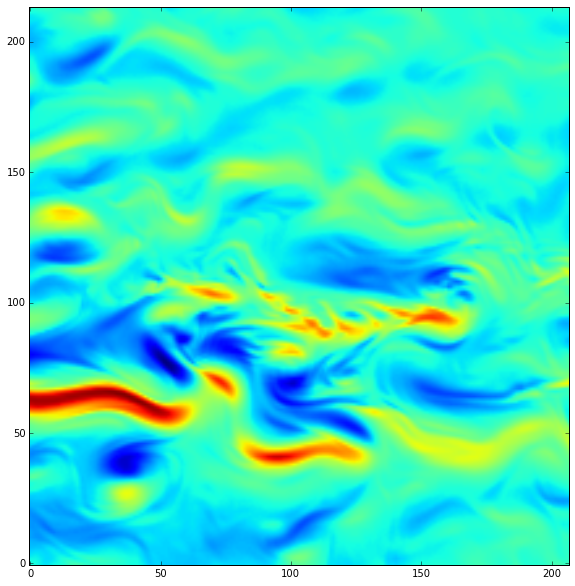

In [160]:
#Default: lonrange=(154.9,171.7), latrange=(30,45.4)
west, est, sud, nord = 154.9-2, 171.7+2, 30.-2, 45.4+2
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])
roll = -1000

base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)
SST = np.roll(f.variables['SST'][0], roll)  # SST(time, lat, lon)
U = np.roll(f.variables['U1_1'][0], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
print imin, imax, jmin, jmax

SST_domain = SST[..., jmin:jmax, imin:imax]
U_domain = U[..., jmin:jmax, imin:imax]
jLs, jLe = (1300,1800)
iLs, iLe = (1500,2400)
print tlat[jLs,iLs], tlat[jLe,iLe], tlon[jLs,iLs], tlon[jLe,iLe]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.imshow(SST_domain, origin='bottom')
plt.subplot(122)
plt.imshow(SST[..., jLs:jLe, iLs:iLe], origin='bottom')

plt.figure(figsize=(10,10))
plt.imshow(U_domain, origin='bottom')

## SST ##

In [91]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb, Ki, isospec_Feb, area, lon, lat = p.power_spectrum_2d(lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Feb = np.zeros(N)
    isospec_sum_Feb += isospec_Feb
    #NtFeb += Nt_Feb

isospec_ave_Feb = isospec_sum_Feb/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [92]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug, Ki, isospec_Aug, area, lon, lat = p.power_spectrum_2d(lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Aug = np.zeros(N)
    isospec_sum_Aug += isospec_Aug
    #NtAug += Nt_Aug

isospec_ave_Aug = isospec_sum_Aug/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


In [93]:
Ns = 20
Ne = N/3
ps_fit_Feb, ps_slope_Feb = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb[Ns:Ne])
ps_fit_Aug, ps_slope_Aug= fit_loglog(Ki[Ns:Ne], isospec_ave_Aug[Ns:Ne])

print ps_slope_Feb, ps_slope_Aug

-2.38904827453 -2.67696640967


In [94]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, dx, dy, L_Feb, SFi, SFj, lon, lat = p.structure_function(lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(L_Feb)
        StrucFunc_sum_Febi = np.zeros(N)
        StrucFunc_sum_Febj = np.zeros(N)
    StrucFunc_sum_Febi += SFi
    StrucFunc_sum_Febj += SFj
    NtFeb += Nt_Feb

StrucFunc_ave_Febi = StrucFunc_sum_Febi/NtFeb
StrucFunc_ave_Febj = StrucFunc_sum_Febj/NtFeb
StrucFunc_ave_Feb = .5*(StrucFunc_ave_Febi+StrucFunc_sum_Febj)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [95]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, dx, dy, L_Aug, SFi, SFj, lon, lat = p.structure_function()
    if yearnum == 1:
        N = len(L_Aug)
        StrucFunc_sum_Augi = np.zeros(N)
        StrucFunc_sum_Augj = np.zeros(N)
    StrucFunc_sum_Augi += SFi
    StrucFunc_sum_Augj += SFj
    NtAug += Nt_Aug

StrucFunc_ave_Augi = StrucFunc_sum_Augi/NtAug
StrucFunc_ave_Augj = StrucFunc_sum_Augj/NtAug
StrucFunc_ave_Aug = .5*(StrucFunc_ave_Augi+StrucFunc_sum_Augj)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


In [96]:
sf_fit_Feb, sf_slope_Feb = fit_loglog(L_Feb, StrucFunc_ave_Feb)
sf_fit_Aug, sf_slope_Aug = fit_loglog(L_Aug, StrucFunc_ave_Aug)

print sf_slope_Feb, sf_slope_Aug

0.992000005519 1.14398761495


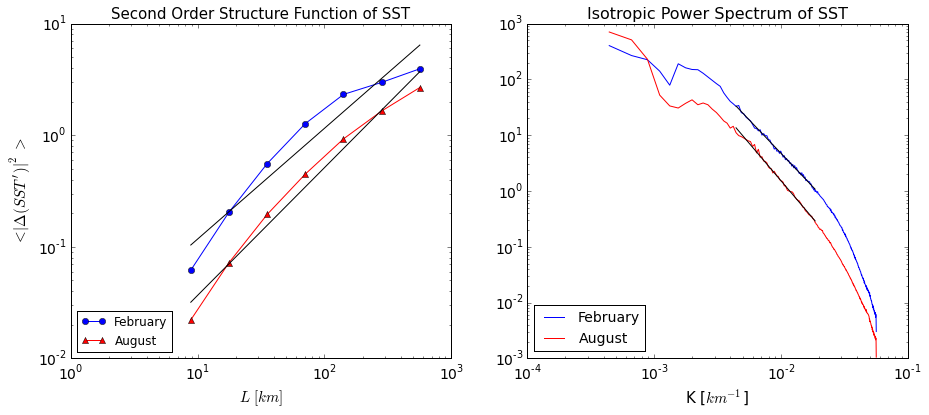

In [97]:
x = 2**np.arange(N)*dx*1e-3
y = 2**np.arange(N)*dy*1e-3

fig = plt.figure(figsize=(15,6))
        
ax1 = fig.add_subplot(121)
ax1.loglog(x, StrucFunc_ave_Feb, 'bo-', label=r'February')
ax1.loglog(x, StrucFunc_ave_Aug, 'r^-', label=r'August') 
ax1.loglog(x, sf_fit_Feb, 'k')
ax1.loglog(x, sf_fit_Aug, 'k')
ax1.set_xlabel('$L \  [km]$', fontsize=15)
ax1.set_ylabel('$< {| \Delta ({SST}^{\ \prime}) |}^2 >$', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title('Second Order Structure Function of SST', fontsize=15)
ax1.legend(loc='lower left')

ax2 = fig.add_subplot(122)
ax2.loglog(Ki*1e3, isospec_ave_Feb, 'b', label=r'February')
ax2.loglog(Ki*1e3, isospec_ave_Aug, 'r', label=r'August')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb, 'k')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug, 'k')
ax2.set_xlabel('K [$km^{-1}$]', fontsize=15)
ax2.set_title('Isotropic Power Spectrum of SST', fontsize=16)
ax2.legend(loc='lower left', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

The SST structure-function slopes are 0.99 and 1.14 and spectral slopes are -2.39 and -2.68 for February and August respectively.

## Surface Velocity and SSH ##

In [117]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb_u, Ki, isospec_Feb_u, area, lon_vel, lat_vel = p.power_spectrum_2d(
                                                                                        varname='U1_1', lonname='ULONG', latname='ULAT', maskname='KMU',
                                                                                                                                                        lonrange=(west,est), latrange=(sud,nord))
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb_v, Ki, isospec_Feb_v, area, lon_vel, lat_vel = p.power_spectrum_2d(
                                                                                        varname='V1_1', lonname='ULONG', latname='ULAT', maskname='KMU',
                                                                                                                                                        lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Feb_u = np.zeros(N)
        isospec_sum_Feb_v = np.zeros(N)
    isospec_sum_Feb_u += isospec_Feb_u
    isospec_sum_Feb_v += isospec_Feb_v
    #NtFeb += Nt_Feb

isospec_ave_Feb_u = isospec_sum_Feb_u/yearnum
isospec_ave_Feb_v = isospec_sum_Feb_v/yearnum
isospec_ave_Feb_Vel = .5*(isospec_Feb_u + isospec_Feb_v)

sstanalysis/popmodel.py:146: UserWarning: The sector has land (land_fraction=4.49388e-05) but we are interpolating it out.
  
sstanalysis/popmodel.py:221: RuntimeWarning: invalid value encountered in divide
  isotropic_spectrum = np.ma.masked_invalid(


../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [105]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug_u, Ki, isospec_Aug_u, area, lon_vel, lat_vel = p.power_spectrum_2d(
                                                                                        varname='U1_1', lonname='ULONG', latname='ULAT', maskname='KMU',
                                                                                                                                                    lonrange=(west,est), latrange=(sud,nord))
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug_v, Ki, isospec_Aug_v, area, lon_vel, lat_vel = p.power_spectrum_2d(
                                                                                        varname='V1_1', lonname='ULONG', latname='ULAT', maskname='KMU',
                                                                                                                                                    lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Aug_u = np.zeros(N)
        isospec_sum_Aug_v = np.zeros(N)
    isospec_sum_Aug_u += isospec_Aug_u
    isospec_sum_Aug_v += isospec_Aug_v
    #NtFeb += Nt_Feb

isospec_ave_Aug_u = isospec_sum_Aug_u/yearnum
isospec_ave_Aug_v = isospec_sum_Aug_v/yearnum
isospec_ave_Aug_Vel = .5*(isospec_Aug_u + isospec_Aug_v)

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-08-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-08-01.nc


In [106]:
NtFeb = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-02-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Feb, Nx, Ny, k, l, PSD_sum_Feb_H, Ki, isospec_Feb_H, area, lon_vel, lat_vel = p.power_spectrum_2d(
                                                                                        varname='SSH_2', lonrange=(west,est), latrange=(sud,nord))
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Feb_H = np.zeros(N)
    isospec_sum_Feb_H += isospec_Feb_H
    #NtFeb += Nt_Feb

isospec_ave_Feb_H = isospec_sum_Feb_H/yearnum

../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0047-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0048-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0049-02-01.nc
../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0050-02-01.nc


In [ ]:
NtAug = 0.
# load data files
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'

nday = 1
for yearnum in np.arange(1,6):
    daynum = 0
    #for month in np.arange(1,13):
    fname = os.path.join(base_dir, 
                         'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday%1d.%04d-08-01.nc' 
                         % (nday, yearnum+45))
    print fname
    p = popmodel.POPFile(fname)
    #T = p.nc.variables['SST'][:]
    Nt_Aug, Nx, Ny, k, l, PSD_sum_Aug_H, Ki, isospec_Aug_H, area, lon_SST, lat_SST = p.power_spectrum_2d(
                                                                                        varname='SSH_2', lonname='TLONG', latname='TLAT', maskname='KMT')
    if yearnum == 1:
        N = len(Ki)
        isospec_sum_Aug_H = np.zeros(N)
    isospec_sum_Aug_H += isospec_Aug_H
    #NtFeb += Nt_Feb

isospec_ave_Aug_SSH = isospec_sum_Aug_H/yearnum

In [107]:
Ns = 20
Ne = N/3
ps_fit_Feb_Vel, ps_slope_Feb_Vel = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb_Vel[Ns:Ne])
ps_fit_Aug_Vel, ps_slope_Aug_Vel = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug_Vel[Ns:Ne])

ps_fit_Feb_SSH, ps_slope_Feb_SSH = fit_loglog(Ki[Ns:Ne], isospec_ave_Feb_SSH[Ns:Ne])
ps_fit_Aug_SSH, ps_slope_Aug_SSH = fit_loglog(Ki[Ns:Ne], isospec_ave_Aug_SSH[Ns:Ne])

print ps_slope_Feb_Vel, ps_slope_Aug_Vel
print ps_slope_Feb_SSH, ps_slope_Aug_SSH

-2.86794290922 -4.04148402382
-4.08713091052 -5.37114118698


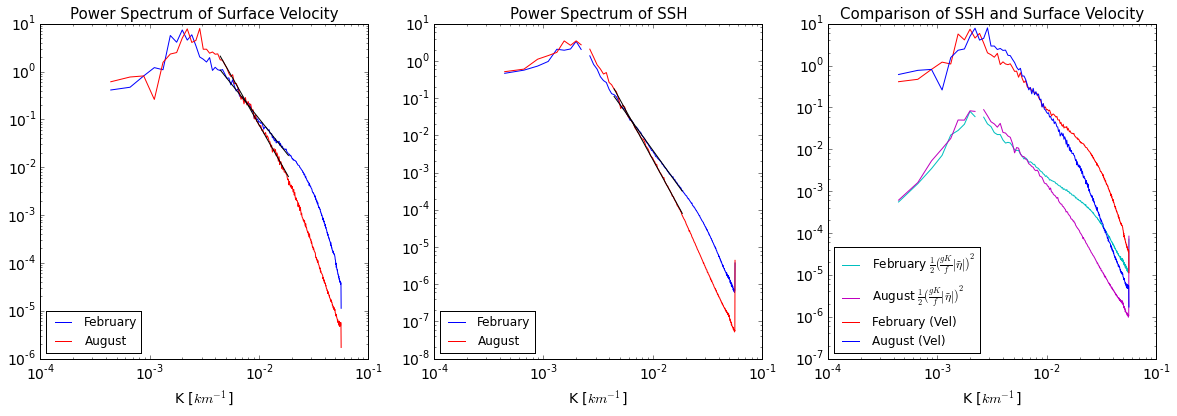

In [108]:
grav = gfd.g
cori = gfd.f_coriolis(.5*(lat_SST[0,0]+lat_SST[-1,0]))

fig = plt.figure(figsize=(20,6))
        
ax1 = fig.add_subplot(131)
ax1.loglog(Ki*1e3, isospec_ave_Feb_Vel, 'b', label=r'February')
ax1.loglog(Ki*1e3, isospec_ave_Aug_Vel, 'r', label=r'August')
ax1.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb_Vel, 'k')
ax1.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug_Vel, 'k')
ax1.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_title('Power Spectrum of Surface Velocity', fontsize=15)
ax1.legend(loc='lower left')

ax2 = fig.add_subplot(132)
ax2.loglog(Ki*1e3, isospec_ave_Feb_SSH, 'b', label=r'February')
ax2.loglog(Ki*1e3, isospec_ave_Aug_SSH, 'r', label=r'August')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Feb_SSH, 'k')
ax2.loglog(Ki[Ns:Ne]*1e3, ps_fit_Aug_SSH, 'k')
ax2.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_title('Power Spectrum of SSH', fontsize=15)
ax2.legend(loc='lower left')

ax3 = fig.add_subplot(133)
ax3.loglog(Ki*1e3, .5*(grav*Ki/cori)**2*isospec_ave_Feb_SSH, 'c', label=r'February $\frac{1}{2}{(\frac{gK}{f}|\tilde{\eta}|)}^2$')
ax3.loglog(Ki*1e3, .5*(grav*Ki/cori)**2*isospec_ave_Aug_SSH, 'm', label=r'August $\frac{1}{2}{(\frac{gK}{f}|\tilde{\eta}|)}^2$')
ax3.loglog(Ki*1e3, isospec_ave_Feb_Vel, 'r', label=r'February (Vel)')
ax3.loglog(Ki*1e3, isospec_ave_Aug_Vel, 'b', label=r'August (Vel)')
ax3.set_xlabel('K [$km^{-1}$]', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_title('Comparison of SSH and Surface Velocity', fontsize=15)
ax3.legend(loc='lower left')

The kinetic-energy spectral slopes are -2.87 and -4.04 and SSH spectral slopes are -4.09 and -5.37 for February and August respectively.